# Subjectivity in News Articles

## Group:
- Luca Babboni - luca.babboni2@studio.unibo.it
- Matteo Fasulo - matteo.fasulo@studio.unibo.it
- Luca Tedeschini - luca.tedeschini3@studio.unibo.it

## Description

This notebook addresses Task 1 proposed in [CheckThat Lab](https://checkthat.gitlab.io/clef2025/) of CLEF 2025. In this task, systems are challenged to distinguish whether a sentence from a news article expresses the subjective view of the author behind it or presents an objective view on the covered topic instead.

This is a binary classification tasks in which systems have to identify whether a text sequence (a sentence or a paragraph) is subjective (SUBJ) or objective (OBJ).

The task comprises three settings:

* Monolingual: train and test on data in a given language
* Multilingual: train and test on data comprising several languages
* Zero-shot: train on several languages and test on unseen languages

training data in five languages:
* Arabic
* Bulgarian
* English
* German
* Italian

The official evaluation is macro-averaged F1 between the two classes.

In [ ]:
%%capture
%pip install -U transformers[torch] bitsandbytes trl peft sacremoses ctranslate2 accelerate

In [ ]:
import os
os.kill(os.getpid(), 9)

In [4]:
from collections import defaultdict
import os
import gc
from pathlib import Path

import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F

from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from sentence_transformers import SentenceTransformer
from datasets import Dataset
from huggingface_hub import notebook_login
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    Trainer, 
    TrainingArguments, 
    DataCollatorWithPadding, 
    BitsAndBytesConfig,
    DebertaV2Model, 
    ModernBertModel, 
    DebertaV2Config, 
    ModernBertConfig, 
    pipeline 
)
from transformers.trainer_utils import PredictionOutput

In [5]:
SEED = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tqdm.pandas() # display tqdm on pandas apply functions
print(f"Using device: {device}")

Using device: cuda


In [6]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [7]:
class Subjectivity:
    def __init__(self, data_folder: str = 'data', seed: int = 42, device: str = 'cuda'):
        self.seed = seed
        self.device = device
        self.languages = [language for language in os.listdir(data_folder)]

        dataset = self.create_dataset(data_folder=data_folder)
        self.dataset = dataset
        
        train, dev, test = self.get_splits(dataset, print_shapes=True)
        self.train = train
        self.dev = dev
        self.test = test

        self.all_data = self.get_per_lang_dataset()
        

    def create_dataset(self, data_folder: str = 'data'):
        dataset = pd.DataFrame(columns=['sentence_id','sentence','label','lang','split'])
        for language in os.listdir(data_folder):
            for filename in os.listdir(f"{data_folder}{os.sep}{language}"):
                if '.tsv' in filename:
                    abs_path = f"{data_folder}{os.sep}{language}{os.sep}{filename}"
                    df = pd.read_csv(abs_path, sep='\t', quoting=csv.QUOTE_NONE)
                    if 'solved_conflict' in df.columns:
                        df.drop(columns=['solved_conflict'], inplace=True)
                    df['lang'] = language
                    df['split'] = Path(filename).stem
                    dataset = pd.concat([dataset, df], axis=0)
        return dataset

    def get_splits(self, dataset: pd.DataFrame, print_shapes: bool = True):
        train = dataset[dataset['split'].str.contains('train')].copy()
        dev = dataset[(dataset['split'].str.contains('dev')) & ~(dataset['split'].str.contains('dev_test'))].copy()
        test = dataset[dataset['split'].str.contains('dev_test')].copy()

        # encode the target variable to int (0: obj; 1: subj)
        train.loc[:, 'label'] = train['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
        dev.loc[:, 'label'] = dev['label'].apply(lambda x: 0 if x == 'OBJ' else 1)
        test.loc[:, 'label'] = test['label'].apply(lambda x: 0 if x == 'OBJ' else 1)

        # cast to int
        train['label'] = train['label'].astype(int)
        dev['label'] = dev['label'].astype(int)
        test['label'] = test['label'].astype(int)

        if print_shapes:
            print(f"Train: {train.shape}")
            print(f"Dev: {dev.shape}")
            print(f"Test: {test.shape}")
            
        return train, dev, test

    def get_per_lang_dataset(self):
        """
        dataset_dict = {
            'english': {
                'train': ...
                'dev': ...
                'test': ...
            },
        }
        """
        dataset_dict = {}
        for language in self.languages:
            dataset_dict[language] = {}
            # get the train data
            dataset_dict[language]['train'] = self.train[self.train['lang']==language].copy()
            # get the dev data
            dataset_dict[language]['dev'] = self.dev[self.dev['lang']==language].copy()
            # get the test data
            dataset_dict[language]['test'] = self.test[self.test['lang']==language].copy()
        return dataset_dict

    def print_label_distrib(self, dataset: pd.DataFrame):
        print(dataset['label'].value_counts(normalize=True))

    def get_baseline_model(self, model_name: str = "paraphrase-multilingual-MiniLM-L12-v2"):
        vect = SentenceTransformer(model_name)
        self.vect = vect
        return vect

    def train_baseline_model(self, vect, train_data: pd.DataFrame, test_data: pd.DataFrame, solver: str = 'saga'):
        model = LogisticRegression(class_weight="balanced", solver=solver, random_state=self.seed)
        model.fit(X=vect.encode(train_data['sentence'].values), y=train_data['label'].values)
        predictions = model.predict(X=vect.encode(test_data['sentence'].values)).tolist()

        # eval performances
        perfs = self.evaluate_model(gold_values=test_data['label'].values, predicted_values=predictions)

        return perfs

    def get_tokenizer(self, model_card: str = "microsoft/mdeberta-v3-base"):
        tokenizer = AutoTokenizer.from_pretrained(model_card)
        self.tokenizer = tokenizer
        return tokenizer

    def get_model(self, model_card: str = "microsoft/mdeberta-v3-base", *args, **kwargs):
        model = AutoModelForSequenceClassification.from_pretrained(model_card, *args, **kwargs)
        self.model = model
        return model

    def get_class_weights(self, dataset: pd.DataFrame):
        class_weights = compute_class_weight('balanced', classes=np.unique(dataset['label']), y=dataset['label'])
        return class_weights

    def evaluate_model(self, gold_values, predicted_values):
        acc = accuracy_score(gold_values, predicted_values)
        m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(gold_values, predicted_values, average="macro",
                                                                   zero_division=0)
        p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(gold_values, predicted_values, labels=[1],
                                                                   zero_division=0)
    
        return {
            'macro_F1': m_f1,
            'macro_P': m_prec,
            'macro_R': m_rec,
            'SUBJ_F1': p_f1[0],
            'SUBJ_P': p_prec[0],
            'SUBJ_R': p_rec[0],
            'accuracy': acc
        }

In [8]:
data_folder = '/kaggle/input/clef2025-checkthat/data' # data

In [9]:
detector = Subjectivity(data_folder=data_folder, seed=SEED, device=device)

Train: (6418, 5)
Dev: (2401, 5)
Test: (2332, 5)


In [10]:
detector.print_label_distrib(detector.train)
detector.print_label_distrib(detector.dev)
detector.print_label_distrib(detector.test)

label
0    0.631349
1    0.368651
Name: proportion, dtype: float64
label
0    0.612245
1    0.387755
Name: proportion, dtype: float64
label
0    0.657376
1    0.342624
Name: proportion, dtype: float64


In [ ]:
notebook_login()

In [11]:
results = {}

In [12]:
# Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/trainer.py#L3700 (with some minor changes removing useless parts)
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, weights_dtype=torch.float32, **kwargs):
        super().__init__(*args, **kwargs)
        # Ensure label_weights is a tensor
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=weights_dtype).to(self.args.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Extract labels
        labels = inputs.get("labels")

        # Forward pass
        outputs = model(**inputs)

        # Extract logits 
        logits = outputs.get('logits')

        # Compute loss with class weights for imbalanced data handling
        if self.class_weights is not None:
            loss = F.cross_entropy(logits, labels, weight=self.class_weights)
        else:
            loss = F.cross_entropy(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_best_threshold(self, dataset, ignore_keys=None, metric_key_prefix="test"):
        # Get raw predictions from parent class
        output = super().predict(dataset, ignore_keys, metric_key_prefix)

        # Convert logits to probabilities using softmax (for binary classification)
        logits = output.predictions
        logits_tensor = torch.tensor(logits)
        probabilities = torch.softmax(logits_tensor, dim=-1).numpy()

        # Calculate optimal threshold
        labels = output.label_ids
        thresholds = np.linspace(0.1, 0.9, 100) 

        best_threshold = 0.5  # Default threshold
        best_f1 = 0

        for threshold in thresholds:
            predictions = (probabilities[:, 1] >= threshold).astype(int)
            _, _, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro", zero_division=0)
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        # Return the best threshold found
        return best_threshold
        

    def predict(self, dataset, threshold: float = 0.5, ignore_keys=None, metric_key_prefix="test"):
        # Get raw predictions from parent class
        output = super().predict(dataset, ignore_keys, metric_key_prefix)
        
        # Convert logits to probabilities using softmax (for binary classification)
        logits = output.predictions
        logits_tensor = torch.tensor(logits)
        probabilities = torch.softmax(logits_tensor, dim=-1).numpy()
        
        final_predictions = (probabilities[:, 1] >= threshold).astype(int)

        # Update predictions in the output object
        return PredictionOutput(
            predictions=final_predictions,
            label_ids=output.label_ids,
            metrics=output.metrics
        )

def tokenize_text(texts):
    return tokenizer(texts['sentence'], padding=True, truncation=True, max_length=256, return_tensors='pt')

def evaluate_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                                zero_division=0)
    p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                                zero_division=0)

    return {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

# mDeBERTta v3 base (Arabic)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

In [ ]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

In [ ]:
language = 'arabic'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

In [ ]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}",
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [ ]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

In [ ]:
best_thr = trainer.compute_best_threshold(dataset=dev_data)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[language] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTta v3 base (Bulgarian)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

In [ ]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

In [ ]:
language = 'bulgarian'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

In [ ]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [ ]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

In [ ]:
best_thr = trainer.compute_best_threshold(dataset=dev_data)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[language] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTa-base (English)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

In [ ]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

In [ ]:
language = 'english'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

In [ ]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [ ]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

In [ ]:
best_thr = trainer.compute_best_threshold(dataset=dev_data)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[language] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTta v3 base (German)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

In [ ]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

In [ ]:
language = 'german'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

In [ ]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [ ]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

In [ ]:
best_thr = trainer.compute_best_threshold(dataset=dev_data)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[language] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTa-base (italian)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

In [ ]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

In [ ]:
language = 'italian'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

In [ ]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [ ]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights
)

In [ ]:
best_thr = trainer.compute_best_threshold(dataset=dev_data)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[language] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

# mDeBERTa-base (multilingual)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

In [ ]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

In [ ]:
language = 'multilingual'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

train_data = Dataset.from_pandas(detector.train)
dev_data = Dataset.from_pandas(detector.dev)
test_data = Dataset.from_pandas(detector.test)

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.train)

In [ ]:
model = detector.get_model(
    model_card=f"MatteoFasulo/mdeberta-v3-base-subjectivity-{language}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    #weight_decay=1e-1,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [ ]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights,
)

In [ ]:
best_thr = trainer.compute_best_threshold(dataset=dev_data)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[language] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

---

# ModernBERT-base (English)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

In [ ]:
model_card = "answerdotai/ModernBERT-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

In [ ]:
language = 'english'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

In [ ]:
model = detector.get_model(
    model_card=f"MatteoFasulo/ModernBERT-base-subjectivity-{language}", 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"ModernBERT-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [ ]:
# Create a Trainer instance
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=dev_data,
    data_collator=collator_fn,
    compute_metrics=evaluate_metrics,
    class_weights=class_weights,
)

In [ ]:
best_thr = trainer.compute_best_threshold(dataset=dev_data)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results['english-modern-bert'] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

---

# Llama-3.2-1B (English)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

In [ ]:
model_card = "meta-llama/Llama-3.2-1B" # meta-llama/Meta-Llama-3-8B
language = 'english'

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit = False, # enable 4-bit quantization
    bnb_4bit_quant_type = 'nf4', # information theoretically optimal dtype for normally distributed weights
    bnb_4bit_use_double_quant = True, # quantize quantized weights
    bnb_4bit_compute_dtype = torch.bfloat16 # optimized fp format for ML
)

lora_config = LoraConfig(
    r = 16, # the dimension of the low-rank matrices
    lora_alpha = 8, # scaling factor for LoRA activations vs pre-trained weight activations
    target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj'],
    lora_dropout = 0.05, # dropout probability of the LoRA layers
    bias = 'none', # wether to train bias weights, set to 'none' for attention layers
    task_type = 'SEQ_CLS'
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_card, add_prefix_space=True)
model = AutoModelForSequenceClassification.from_pretrained(
    f"MatteoFasulo/Llama-3.2-1B-subjectivity-{language}",
    #quantization_config=quantization_config,
    num_labels=2,
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
model = prepare_model_for_kbit_training(model)
model

In [ ]:
model = get_peft_model(model, lora_config)
model

In [ ]:
model.config.pad_token_id = tokenizer.pad_token_id
model.config.use_cache = False
model.config.pretraining_tp = 1

In [ ]:
epochs = 6
batch_size = 16
lr = 1e-4
weight_decay = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"Llama-3.2-1B-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [ ]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

In [ ]:
best_thr = trainer.compute_best_threshold(dataset=dev_data)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"llama3.2-1B-{language}"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

---

# Test - Translating Arab to English

In [13]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

0

In [14]:
model_card = "answerdotai/ModernBERT-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = AutoModelForSequenceClassification.from_pretrained(
    model_card, 
    num_labels=2, 
    id2label={0: 'OBJ', 1: 'SUBJ'}, 
    label2id={'OBJ': 0, 'SUBJ': 1},
    output_attentions = False,
    output_hidden_states = False
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
language = 'arabic'

In [ ]:
!ct2-transformers-converter --model Helsinki-NLP/opus-mt-ar-en --output_dir opus-mt-ar-en

In [ ]:
import ctranslate2
import transformers

translator = ctranslate2.Translator("opus-mt-ar-en", device='cuda')
tokenizer = transformers.AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-ar-en")

def translate_text(raw_text):
    source = tokenizer.convert_ids_to_tokens(tokenizer.encode(raw_text))
    results = translator.translate_batch([source])
    target = results[0].hypotheses[0]
    translation = tokenizer.decode(tokenizer.convert_tokens_to_ids(target))
    return translation

In [ ]:
detector.all_data[language]['train']['translated_sentence'] = detector.all_data[language]['train']['sentence'].progress_apply(translate_text)

In [ ]:
detector.all_data[language]['dev']['translated_sentence'] = detector.all_data[language]['dev']['sentence'].progress_apply(translate_text)

In [ ]:
detector.all_data[language]['test']['translated_sentence'] = detector.all_data[language]['test']['sentence'].progress_apply(translate_text)

In [ ]:
detector.all_data[language]['train'].to_csv('/kaggle/working/train_ar.csv')
detector.all_data[language]['dev'].to_csv('/kaggle/working/dev_ar.csv')
detector.all_data[language]['test'].to_csv('/kaggle/working/dev_test_ar.csv')

In [16]:
detector.all_data[language]['train'] = pd.read_csv('/kaggle/working/train_ar.csv')
detector.all_data[language]['dev'] = pd.read_csv('/kaggle/working/dev_ar.csv')
detector.all_data[language]['test'] = pd.read_csv('/kaggle/working/dev_test_ar.csv')

In [17]:
epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

def tokenize_text(texts):
    return tokenizer(texts['translated_sentence'], padding=True, truncation=True, max_length=256, return_tensors='pt')

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

Map:   0%|          | 0/2446 [00:00<?, ? examples/s]

Map:   0%|          | 0/467 [00:00<?, ? examples/s]

Map:   0%|          | 0/748 [00:00<?, ? examples/s]

In [18]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"ModernBERT-base-subjectivity-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [19]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights
)

In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro P,Macro R,Subj F1,Subj P,Subj R,Accuracy
1,No log,0.685731,0.538930,0.557348,0.555746,0.556701,0.475352,0.671642,0.539615
2,No log,0.696614,0.544413,0.557714,0.550013,0.424419,0.510490,0.363184,0.576017
3,No log,0.726701,0.534970,0.544084,0.539343,0.420455,0.490066,0.368159,0.563169
4,0.647700,0.755695,0.525088,0.525070,0.525184,0.463054,0.458537,0.467662,0.533191
5,0.647700,0.852189,0.534913,0.536520,0.535359,0.450262,0.475138,0.427861,0.550321
6,0.647700,0.868179,0.520145,0.520679,0.520321,0.441026,0.455026,0.427861,0.533191


TrainOutput(global_step=918, training_loss=0.5380588772509872, metrics={'train_runtime': 563.0125, 'train_samples_per_second': 26.067, 'train_steps_per_second': 1.631, 'total_flos': 2471178561478704.0, 'train_loss': 0.5380588772509872, 'epoch': 6.0})

{'macro_F1': 0.5374902369174694, 'macro_P': 0.5377207178048693, 'macro_R': 0.5382043343653251, 'SUBJ_F1': 0.48802395209580846, 'SUBJ_P': 0.47246376811594204, 'SUBJ_R': 0.5046439628482973, 'accuracy': 0.5427807486631016}


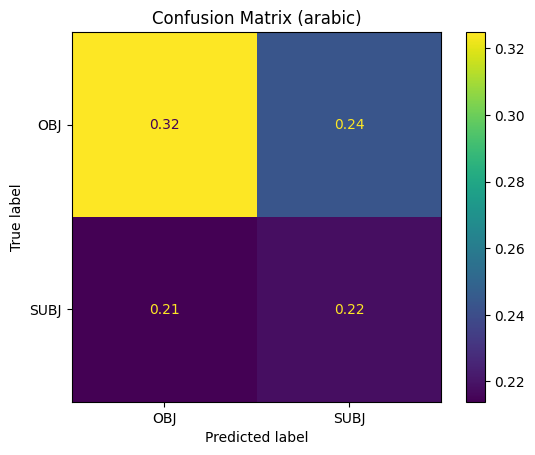

In [21]:
best_thr = trainer.compute_best_threshold(dataset=dev_data)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"llama3.2-1B-{language}"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language})")
plt.show()

---

# mdeberta-v3-base (english + sentiment)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, model_name="microsoft/mdeberta-v3-base", num_labels=2, sentiment_dim=3):
        super().__init__()
        self.model = DebertaV2Model.from_pretrained(model_name)
        self.config = DebertaV2Config
        hidden_size = self.model.config.hidden_size
  
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size + sentiment_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, positive, neutral, negative, attention_mask=None, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
        cls_embedding = last_hidden_state[:, 0, :]  # Get CLS token embedding
        
        # Sentiment features as a single tensor
        sentiment_features = torch.stack((positive, neutral, negative), dim=1)  # Shape: (batch_size, 3)
        
        # Combine CLS embedding with sentiment features
        combined_features = torch.cat((cls_embedding, sentiment_features), dim=1)
        
        # Classification head
        logits = self.classifier(combined_features)
        
        return {'logits': logits}

In [ ]:
language = 'english'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

In [ ]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = CustomModel(
    model_name=f"MatteoFasulo/mdeberta-v3-base-subjectivity-sentiment-{language}", 
    num_labels=2, 
    sentiment_dim=3
)

In [ ]:
pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment", tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment", top_k=None)

def extract_sentiment(text):
    sentiments = pipe(text)[0]
    return {k:v for k,v in [(list(sentiment.values())[0], list(sentiment.values())[1]) for sentiment in sentiments]}

detector.all_data[language]['train'][['positive', 'neutral', 'negative']] = detector.all_data[language]['train'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['dev'][['positive', 'neutral', 'negative']] = detector.all_data[language]['dev'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['test'][['positive', 'neutral', 'negative']] = detector.all_data[language]['test'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

In [ ]:
train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-sentiment-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [ ]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

In [ ]:
best_thr = trainer.compute_best_threshold(dataset=dev_data)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-sentiment"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language}-sentiment)")
plt.show()

# mdeberta-v3-base (german + sentiment)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

if 'model' in locals() or 'model' in globals():
    del model
    print("Model deleted!")

gc.collect()

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, model_name="microsoft/mdeberta-v3-base", num_labels=2, sentiment_dim=3):
        super().__init__()
        self.model = DebertaV2Model.from_pretrained(model_name)
        self.config = DebertaV2Config
        hidden_size = self.model.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size + sentiment_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, positive, neutral, negative, attention_mask=None, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
        pooled_output = last_hidden_state[:, 0, :]  # Prendiamo il token [CLS] (prima posizione)
        
        # Concatenate with sentiment features
        positive = positive.unsqueeze(1)
        neutral = neutral.unsqueeze(1)
        negative = negative.unsqueeze(1)
        sentiment_features = torch.cat((positive, neutral, negative), dim=1)
        combined_features = torch.cat((pooled_output, sentiment_features), dim=1)
        
        # Pass through custom classification head
        logits = self.classifier(combined_features)
        
        return {'logits': logits}

In [ ]:
language = 'german'

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0

In [ ]:
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)
model = CustomModel(
    model_name=model_card, 
    num_labels=2, 
    sentiment_dim=3
)

In [ ]:
pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment", tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment", top_k=None)

def extract_sentiment(text):
    sentiments = pipe(text)[0]
    return {k:v for k,v in [(list(sentiment.values())[0], list(sentiment.values())[1]) for sentiment in sentiments]}

detector.all_data[language]['train'][['positive', 'neutral', 'negative']] = detector.all_data[language]['train'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['dev'][['positive', 'neutral', 'negative']] = detector.all_data[language]['dev'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
detector.all_data[language]['test'][['positive', 'neutral', 'negative']] = detector.all_data[language]['test'].progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

In [ ]:
train_data = Dataset.from_pandas(detector.all_data[language]['train'])
dev_data = Dataset.from_pandas(detector.all_data[language]['dev'])
test_data = Dataset.from_pandas(detector.all_data[language]['test'])

train_data = train_data.map(tokenize_text, batched=True)
dev_data = dev_data.map(tokenize_text, batched=True)
test_data = test_data.map(tokenize_text, batched=True)

collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

class_weights = detector.get_class_weights(detector.all_data[language]['train'])

In [ ]:
# Define training args
training_args = TrainingArguments(
    output_dir=f"mdeberta-v3-base-subjectivity-sentiment-{language}",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

In [ ]:
trainer = CustomTrainer(
    model = model,
    args = training_args,
    train_dataset = train_data,
    eval_dataset = dev_data,
    data_collator = collator_fn,
    compute_metrics = evaluate_metrics,
    class_weights=class_weights,
)

In [ ]:
trainer.train()

In [ ]:
best_thr = trainer.compute_best_threshold(dataset=dev_data)
pred_info = trainer.predict(dataset=test_data, threshold=best_thr)

predictions, labels = pred_info.predictions, pred_info.label_ids

acc = accuracy_score(labels, predictions)
m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                            zero_division=0)
p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                            zero_division=0)
stats = {
        'macro_F1': m_f1,
        'macro_P': m_prec,
        'macro_R': m_rec,
        'SUBJ_F1': p_f1[0],
        'SUBJ_P': p_prec[0],
        'SUBJ_R': p_rec[0],
        'accuracy': acc
    }

print(stats)
results[f"{language}-sentiment"] = stats

cm = confusion_matrix(labels, predictions, normalize='all')
ConfusionMatrixDisplay(cm, display_labels=['OBJ', 'SUBJ']).plot()
plt.title(f"Confusion Matrix ({language}-sentiment)")
plt.show()

In [ ]:
pd.DataFrame(results).T.sort_values(by='macro_F1', ascending=False).round(4)

---

# Zero shot inference

## Utility function

This function can be then integrated in the Subjectivity class

In [ ]:
def zero_shot_prepare_data(train_languages : list,
                           train : pd.DataFrame,
                           dev : pd.DataFrame,
                           test : pd.DataFrame):

    
    train_set = train[train["lang"].isin(train_languages)].copy()
    dev_set = dev[~dev["lang"].isin(train_languages)].copy()
    test_set = test[~test["lang"].isin(train_languages)].copy()

    return train_set, dev_set, test_set

In [ ]:
def generate_name(names : tuple):
    generated_name = ""
    for x in names:
        generated_name = generated_name + x.capitalize()[:2]
    return generated_name

## Custom loop to test triplets

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, model_name="microsoft/mdeberta-v3-base", num_labels=2, sentiment_dim=3):
        super().__init__()
        self.model = DebertaV2Model.from_pretrained(model_name)
        self.config = DebertaV2Config
        hidden_size = self.model.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size + sentiment_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, positive, neutral, negative, attention_mask=None, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
        pooled_output = last_hidden_state[:, 0, :]  # Prendiamo il token [CLS] (prima posizione)
        
        # Concatenate with sentiment features
        positive = positive.unsqueeze(1)
        neutral = neutral.unsqueeze(1)
        negative = negative.unsqueeze(1)
        sentiment_features = torch.cat((positive, neutral, negative), dim=1)
        combined_features = torch.cat((pooled_output, sentiment_features), dim=1)
        
        # Pass through custom classification head
        logits = self.classifier(combined_features)
        
        return {'logits': logits}

In [ ]:
def extract_sentiment(text):
    sentiments = pipe(text)[0]
    return {k:v for k,v in [(list(sentiment.values())[0], list(sentiment.values())[1]) for sentiment in sentiments]}


In [ ]:
import itertools
results = {}
model_card = "microsoft/mdeberta-v3-base"
tokenizer = detector.get_tokenizer(model_card=model_card)

epochs = 6
batch_size = 16
lr = 1e-5
weight_decay = 0.0
label_smoothing = 0.0

training_args = TrainingArguments(
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=lr,
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    #warmup_ratio=0.5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

pipe = pipeline("sentiment-analysis", model="cardiffnlp/twitter-xlm-roberta-base-sentiment", tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment", top_k=None)



for i, group in enumerate(itertools.combinations(detector.languages, 3)):
    print(f"TESTING {i} - {group}")
    with torch.no_grad():
        torch.cuda.empty_cache()
    if 'model' in locals() or 'model' in globals():
        del model
        print("Model deleted!")
    gc.collect()
    
    group_name = generate_name(group)

    zs_train, zs_dev, zs_test = zero_shot_prepare_data(group, detector.train, detector.dev, detector.test)

    language = group_name+'-NoSentiment'


    
    train_data = Dataset.from_pandas(zs_train)
    dev_data = Dataset.from_pandas(zs_dev)
    test_data = Dataset.from_pandas(zs_test)
    
    train_data = train_data.map(tokenize_text, batched=True)
    dev_data = dev_data.map(tokenize_text, batched=True)
    test_data = test_data.map(tokenize_text, batched=True)
    
    class_weights = detector.get_class_weights(zs_train)

    model = detector.get_model(
        model_card=model_card, 
        num_labels=2, 
        id2label={0: 'OBJ', 1: 'SUBJ'}, 
        label2id={'OBJ': 0, 'SUBJ': 1},
        output_attentions = False,
        output_hidden_states = False
    )
    
    collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=dev_data,
        data_collator=collator_fn,
        compute_metrics=evaluate_metrics,
        class_weights=class_weights,
    )

    trainer.train()

    pred_info = trainer.predict(test_data)
    predictions, labels = pred_info.predictions, pred_info.label_ids
    
    acc = accuracy_score(labels, predictions)
    m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                                zero_division=0)
    p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                                zero_division=0)
    stats = {
            'macro_F1': m_f1,
            'macro_P': m_prec,
            'macro_R': m_rec,
            'SUBJ_F1': p_f1[0],
            'SUBJ_P': p_prec[0],
            'SUBJ_R': p_rec[0],
            'accuracy': acc
        }
    
    results[language] = stats

    
    with torch.no_grad():
        torch.cuda.empty_cache()
    if 'model' in locals() or 'model' in globals():
        del model
        print("Model deleted!")
    gc.collect()

    language = group_name+'-Sentiment'
    
    model = CustomModel(
        model_name=model_card, 
        num_labels=2, 
        sentiment_dim=3
    )



    zs_train[['positive', 'neutral', 'negative']] = zs_train.progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
    zs_dev[['positive', 'neutral', 'negative']] = zs_dev.progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')
    zs_test[['positive', 'neutral', 'negative']] = zs_test.progress_apply(lambda x: extract_sentiment(x['sentence']), axis=1, result_type='expand')

    train_data = Dataset.from_pandas(zs_train)
    dev_data = Dataset.from_pandas(zs_dev)
    test_data = Dataset.from_pandas(zs_test)

    train_data = train_data.map(tokenize_text, batched=True)
    dev_data = dev_data.map(tokenize_text, batched=True)
    test_data = test_data.map(tokenize_text, batched=True)

    collator_fn = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = CustomTrainer(
        model = model,
        args = training_args,
        train_dataset = train_data,
        eval_dataset = dev_data,
        data_collator = collator_fn,
        compute_metrics = evaluate_metrics,
        class_weights=class_weights,
    )

    trainer.train()

    pred_info = trainer.predict(test_data)
    predictions, labels = pred_info.predictions, pred_info.label_ids
    
    acc = accuracy_score(labels, predictions)
    m_prec, m_rec, m_f1, m_s = precision_recall_fscore_support(labels, predictions, average="macro",
                                                                zero_division=0)
    p_prec, p_rec, p_f1, p_s = precision_recall_fscore_support(labels, predictions, labels=[1],
                                                                zero_division=0)
    stats = {
            'macro_F1': m_f1,
            'macro_P': m_prec,
            'macro_R': m_rec,
            'SUBJ_F1': p_f1[0],
            'SUBJ_P': p_prec[0],
            'SUBJ_R': p_rec[0],
            'accuracy': acc
        }
    
    results[language] = stats
    
    

In [ ]:
pd.DataFrame(results).T.sort_values(by='macro_F1', ascending=False).round(4)

In [ ]:
dataframe = pd.DataFrame(results)

In [ ]:
dataframe.to_csv("results.csv")